In [1]:
import maxrf4u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.exposure as ske
import moseley as mos
import numpy as np

In [2]:
datastack_file = '/home/koen-van-tilburg/Documents/maxrf4u/data/datastacks/WM-71803-01_400_600_50.datastack'
datastack_file2 = '/home/koen-van-tilburg/Documents/maxrf4u/data/datastacks/WM-71803-10_250_300_50.datastack'
ds = maxrf4u.DataStack(datastack_file)
ds.tree()

/
├── compton_peak_energy (1,) float64
├── hotmax_baselines (32, 4096) float64
├── hotmax_noiselines (32, 4096) float64
├── hotmax_peak_idxs_flat (33,) int64
├── hotmax_peak_idxs_list (32, 2) int64
├── hotmax_spectra (32, 4096) float32
├── hotmax_spots (32, 2) int64
├── hotmax_subpeak_idxs_list (32, 19) int64
├── imvis_extent (4,) int64
├── imvis_reg (583, 355, 3) uint8
├── imvis_reg_ (583, 355, 3) uint8
├── imvis_reg_highres (8256, 5027, 3) uint8
├── imvis_reg_highres_ (8256, 5027, 3) uint8
├── maxrf_cube (583, 355, 4096) float32
├── maxrf_energies (4096,) float64
├── maxrf_maxspectrum (4096,) float32
├── maxrf_sumspectrum (4096,) float64
├── nmf_atomnums (18,) int64
├── nmf_elementmaps (18, 583, 355) float32
├── nmf_gausscomponents (34, 4096) float32
├── nmf_peakmaps (34, 583, 355) float32
└── nmf_peaks2elements_matrix (18, 33) float32

/home/koen-van-tilburg/Documents/maxrf4u/data/datastacks/WM-71803-01_400_600_50.datastack:




In [3]:
imvis_highres = ds.read('imvis_reg_highres')
imvis_reg = ds.read('imvis_reg')
extent = ds.read('imvis_extent')
object_num = 'WM_Pagina1'
element_maps = ds.read('nmf_elementmaps')
atom_nums = ds.read('nmf_atomnums')
elements = mx.elems_from_atomnums(atom_nums)
#ppa = mx.Peak_Pattern_Atlas(datastack_file=datastack_file)
#hma = mx.HotmaxAtlas(datastack_file=datastack_file)

cube = ds.read('maxrf_cube', compute=False)
x_keVs = ds.read('maxrf_energies')

roi = cube[100:130,50:90]
spectrum = roi.reshape(-1, roi.shape[-1])
y_mean = np.mean(spectrum, axis=0)

elem = 'Hg'
xf = mos.XFluo(elem, tube_keV=25)



/home/koen-van-tilburg/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/moseley/mplot.py:304: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


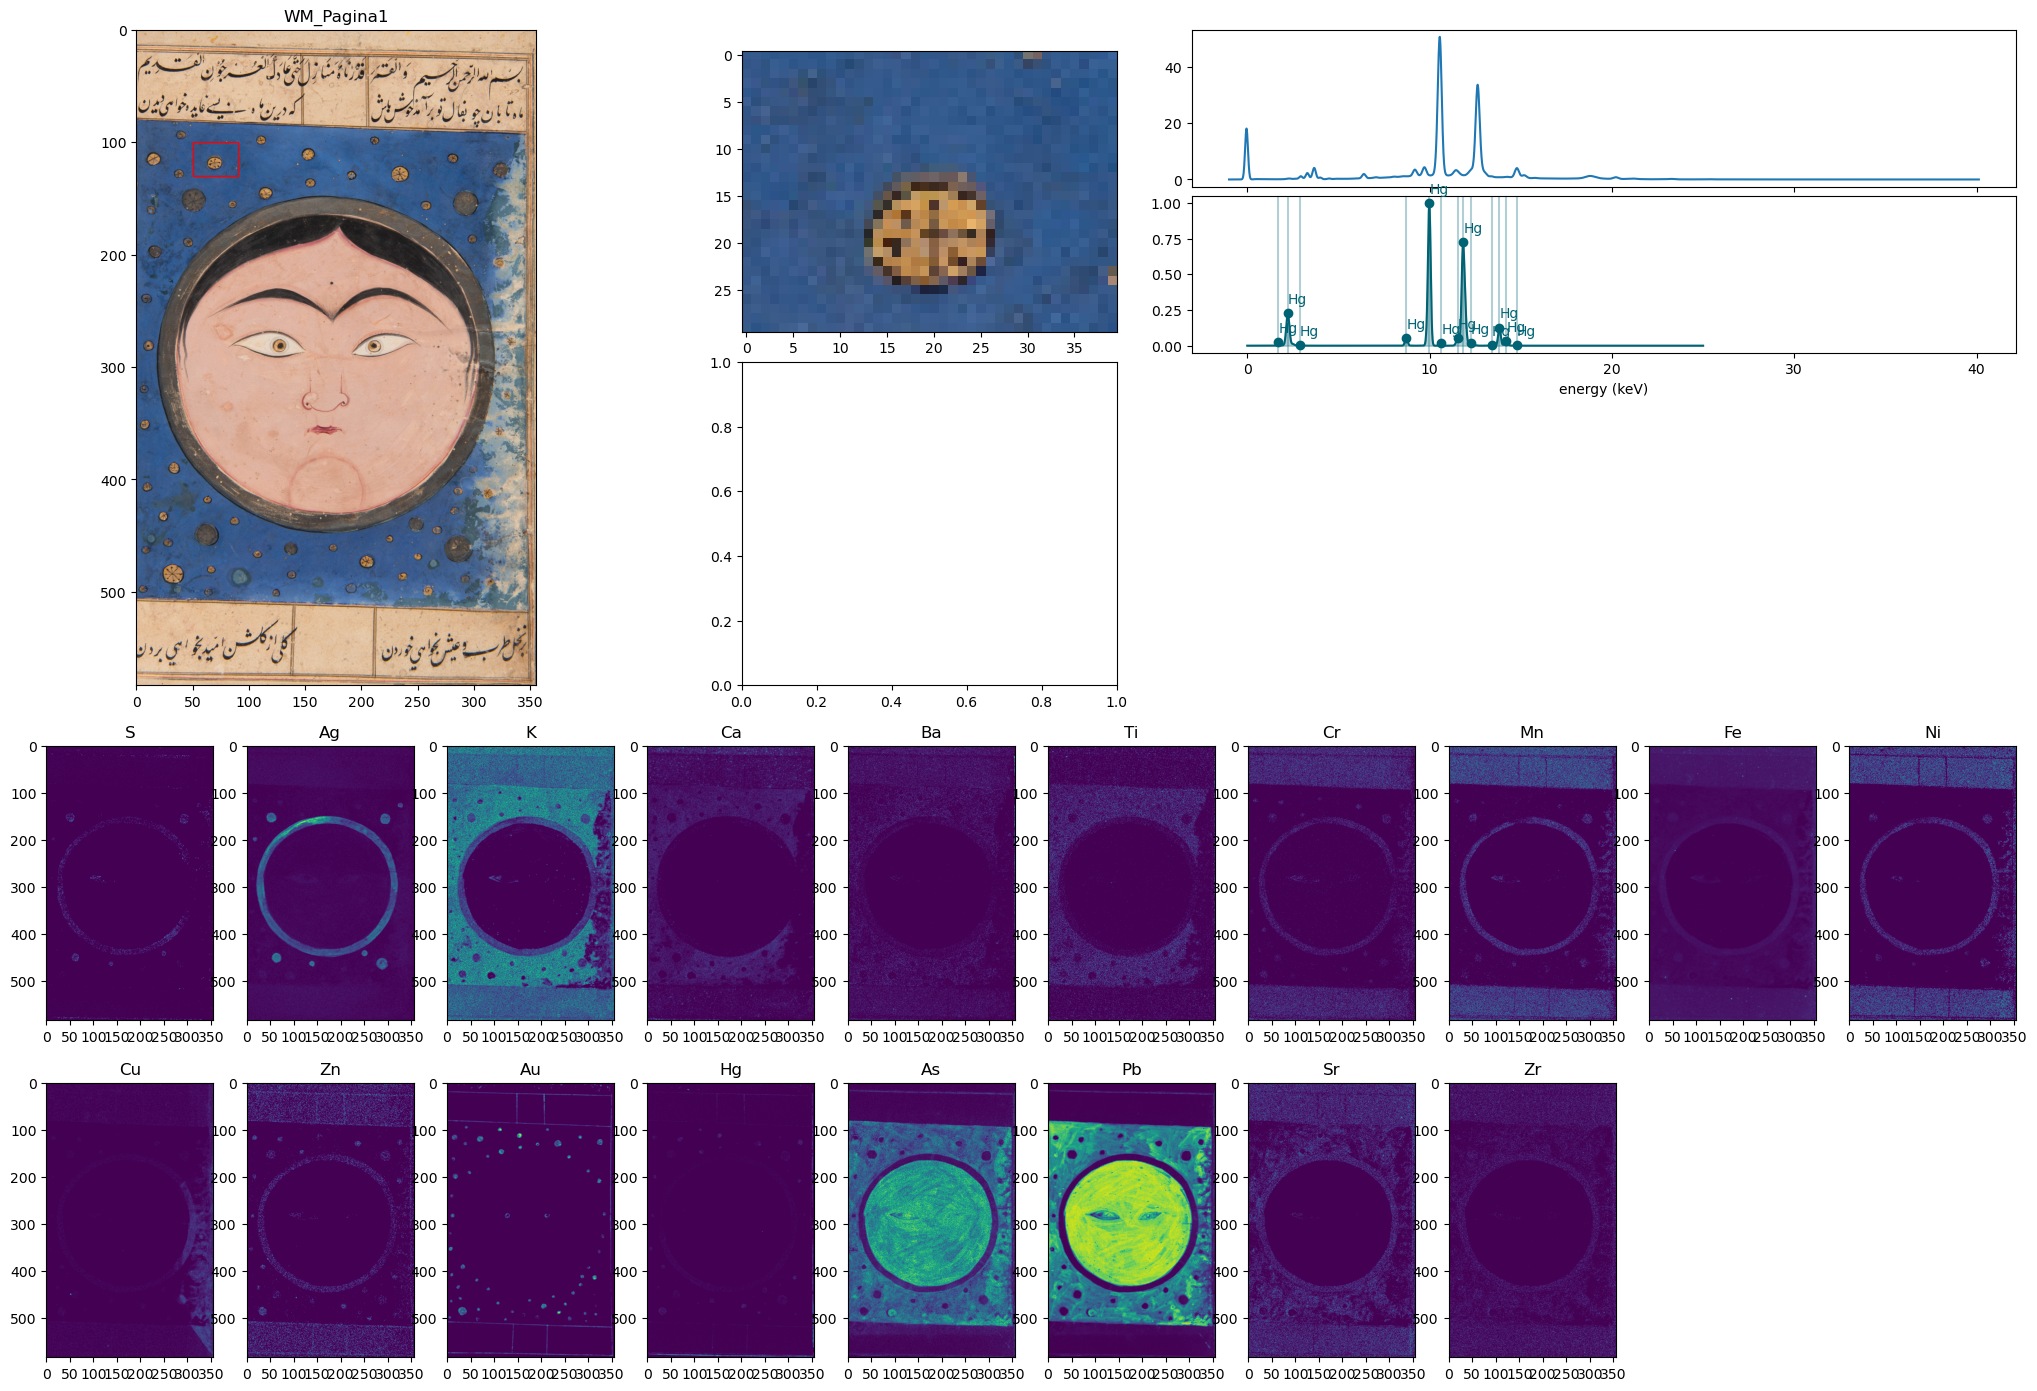

In [4]:
fig = plt.figure(layout='constrained', figsize=(20, 14))
base = fig.add_gridspec(2,1)

#Bovenkant

top_grid = base[0].subgridspec(1,3)

#Highres linksboven
ax_highres = fig.add_subplot(top_grid[0])
ax_highres.imshow(imvis_highres, extent=extent)
ax_highres.set_title(object_num)

rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')
ax_highres.add_patch(rect)

#Regions of interest rechtsboven
roi_grid = top_grid[1:].subgridspec(4, 3)

ax_roi1 = fig.add_subplot(roi_grid[0:2,0])
ax_roi1.imshow(imvis_reg[100:130,50:90])

ax_roi1_spectrum = fig.add_subplot(roi_grid[0,1:])
ax_roi1_spectrum.plot(x_keVs, y_mean)

ax_roi1_mos = fig.add_subplot(roi_grid[1,1:])

ax_roi1_spectrum.sharex(ax_roi1_mos)

xf.plot(ax=ax_roi1_mos)


ax_roi2 = fig.add_subplot(roi_grid[2:4,0])


#Onderkant

bottom_grid = base[1].subgridspec(2,10)

#Genereren previews(in voorbeel element maps)
for i, emap in enumerate(element_maps):
    ax = fig.add_subplot(bottom_grid[i])
    ax.imshow(emap)
    ax.set_title(elements[i])
    ax.sharex(ax_highres)
    ax.sharey(ax_highres)

In [6]:
class Dashboard:

    def __init__(self, datastack_files=None):
        '''Create a dashboard for analyzing spectras on regions of interest

        datastack_files: A list of path strings to all datastacks you want to access in the dashboard can be a singular datastack_file path.
        '''

        if datastack_files == None:
            raise ValueError('datastack_files can not be empty')

        if not isinstance(datastack_files, list):
            self.datastack_files = []
            self.datastack_files.append(datastack_files)
            
        else:
            self.datastack_files = datastack_files

        #Read from datastacks
        ds = maxrf4u.DataStack(self.datastack_files[0])
        self.image = ds.read('imvis_reg_highres')
        self.extent = ds.read('imvis_extent')
        self.image_number = self.datastack_files.index(self.datastack_files[0])
        self.previews = self._generate_previews()
        self.current_preview = self.previews[self.datastack_files.index(self.datastack_files[0])]
        
        #Initialize layout
        self._create_layout()
        self._create_image_plot()
        self._create_roi_plot()
        self._create_preview_plot()

    def _generate_previews(self):
        previews = []
        for datastack_file in self.datastack_files:
            previews.append(maxrf4u.DataStack(datastack_file).read('imvis_reg'))
        return previews
        
    def _create_layout(self):
        #Initialize figure
        self.fig = plt.figure(layout='constrained', figsize=(12, 9))

        #Making base gridspec
        self.base = self.fig.add_gridspec(2,1)

        #Making top half gridspec
        self.top_grid = self.base[0].subgridspec(1,3)

        #Making bottom half gridspec
        self.bottom_grid = self.base[1].subgridspec(2,10)

    def _create_image_plot(self):
        self.ax_image_plot = self.fig.add_subplot(self.top_grid[0])
        self.ax_image_plot.imshow(self.image, extent=self.extent)
        self.ax_image_plot.set_title(self.image_number)

    def _create_roi_plot(self):
        self.roi_count = 2
        self.roi_axs = []
        self.spectrum_axs = []
        self.mos_axs = []
        self.roi_grid = self.top_grid[1:].subgridspec(self.roi_count*2, 3)
        for i in range(self.roi_count):
            ax_roi = self.fig.add_subplot(self.roi_grid[i*2:(i*2)+2,0])
            ax_roi.set_axis_off()
            self.roi_axs.append(ax_roi)
            ax_spectrum = self.fig.add_subplot(self.roi_grid[i*2,1:])
            self.spectrum_axs.append(ax_spectrum)
            ax_mos = self.fig.add_subplot(self.roi_grid[(i*2)+1,1:])
            self.mos_axs.append(ax_mos)
            ax_spectrum.sharex(ax_mos)

    def _create_preview_plot(self):
        self.bottom_grid = self.base[1].subgridspec(2,10)
        for i in range(len(self.previews)):
            ax = self.fig.add_subplot(self.bottom_grid[i])
            ax.imshow(self.previews[i])
            ax.set_title(i)
            ax.set_axis_off()

    def swap_image(self, index):
        ds = maxrf4u.DataStack(self.datastack_files[index])
        self.image = ds.read('imvis_reg_highres')
        self.extent = ds.read('imvis_extent')
        self.image_number = self.datastack_files.index(self.datastack_files[index])
        self.current_preview = self.previews[self.datastack_files.index(self.datastack_files[index])]
        self.ax_image_plot.imshow(self.image, extent=self.extent)
        self.ax_image_plot.set_title(self.image_number)

    def get_selection_coords(self):
        return tuple(int(x) for x in self.ax_image_plot.get_xlim()), tuple(int(x) for x in self.ax_image_plot.get_ylim()),

    def add_roi(self, index, x=None, y=None):
        #Create list of ROI
        self.roi_list = [None] * self.roi_count
        #Add new ROI to list
        self.roi_list[index] = self.current_preview[y[0]:y[1],x[0]:x[1]]
        #Display ROI
        self.roi_axs[index].imshow(self.roi_list[index])
        #Draw rectangle on main image
        rect = patches.Rectangle((x[0], y[0]), x[1]-x[0], y[1]-y[0], linewidth=1, edgecolor='r', facecolor='none')
        self.ax_image_plot.add_patch(rect)
        #Generate spectrum
        cube = maxrf4u.DataStack(self.datastack_files[index]).read('maxrf_cube', compute=False)
        x_keVs = maxrf4u.DataStack(self.datastack_files[index]).read('maxrf_energies')
        roi = cube[y[0]:y[1],x[0]:x[1]]
        spectrum = roi.reshape(-1, roi.shape[-1])
        y_mean = np.mean(spectrum, axis=0)
        self.spectrum_axs[index].plot(x_keVs, y_mean)

    def add_mos_element(self, index, elem):
        xf = mos.XFluo(elem, tube_keV=25)
        xf.plot(ax=self.mos_axs[index])

In [7]:
%matplotlib widget

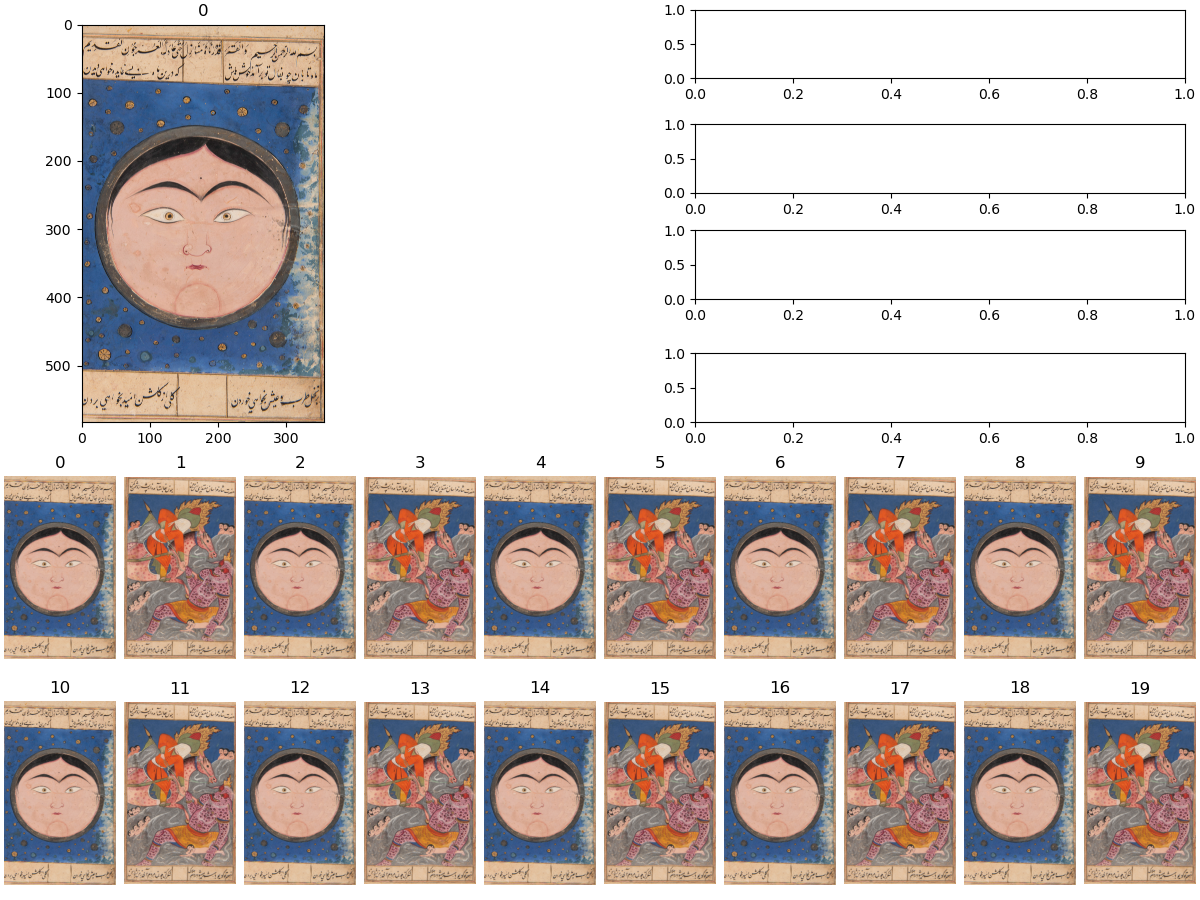

In [8]:
file = [datastack_file, datastack_file2] * 10
dash = Dashboard(file)

In [11]:
dash.add_roi(0, (62, 78), (109, 123))

In [13]:
dash.add_roi(1, (90, 150), (265, 295))

In [14]:
x , y = dash.get_selection_coords()
y = y[::-1]

In [15]:
dash.add_roi(1, x, y)

In [12]:
dash.add_mos_element(0, 'Pb')
dash.add_mos_element(0, 'Au')
dash.add_mos_element(1, 'Pb')

/home/koen-van-tilburg/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/moseley/mplot.py:304: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [16]:
dash.swap_image(1)

In [ ]:
# TODO: Generate other datastack imregs koen
# TODO: Swap Main image
# TODO: Add/Delete ROI regions (saved per datastack and with rectangle and index argument for overwriting)
# TODO: Add/Delete Moseley spectrum for ROI